In [95]:
from salishsea_tools import viz_tools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cmocean.cm as cm
import matplotlib.patches as patches
import gsw


In [96]:
riv_df = pd.read_csv('../../../../../../results/forcing/rivers/observations/Squamish_Brackendale_flow',header=None,delimiter=' ')
mapping = {riv_df.columns[0]: 'YYYY', riv_df.columns[1]: 'MM', riv_df.columns[2]: 'DD', riv_df.columns[3]: 'DISCHARGE'}
river = riv_df.rename(columns=mapping)

In [97]:
river_2018 = river[river['YYYY'] == 2018]

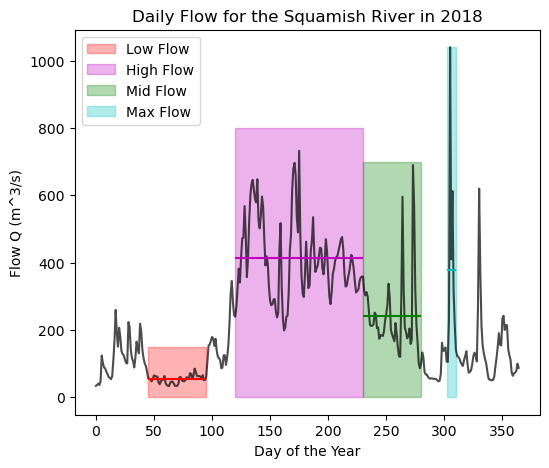

In [98]:
mid_flow = patches.Rectangle((230, 0), 50, 700, linewidth=1, edgecolor='g', facecolor='g',alpha=0.3,label='Mid Flow')
mid_mean = np.mean(river_2018['DISCHARGE'].values[230:280])

low_flow = patches.Rectangle((45, 0), 50, 150, linewidth=1, edgecolor='r', facecolor='r',alpha=0.3,label='Low Flow')
low_mean = np.mean(river_2018['DISCHARGE'].values[45:95])

high_flow = patches.Rectangle((120, 0), 110, 800, linewidth=1, edgecolor='m', facecolor='m',alpha=0.3,label='High Flow')
high_mean = np.mean(river_2018['DISCHARGE'].values[120:230])

max_flow = patches.Rectangle((302, 0), 8, river_2018['DISCHARGE'].max(), linewidth=1, edgecolor='c', facecolor='c',alpha=0.3,label='Max Flow')
max_mean = np.mean(river_2018['DISCHARGE'].values[302:310])


fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.plot(np.arange(len(river_2018)), river_2018['DISCHARGE'],'k',alpha=0.7)
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Flow Q (m^3/s)')
ax.set_title('Daily Flow for the Squamish River in 2018')


ax.add_patch(low_flow)
ax.hlines(low_mean,45,95,color='r')
ax.add_patch(high_flow)
ax.add_patch(mid_flow)
ax.hlines(mid_mean,230,280,color='g')
ax.hlines(high_mean,120,230,color='m')
ax.add_patch(max_flow)
ax.hlines(max_mean,302,310,color='c')

ax.legend()

In [99]:
# make a mask of land where land is true and water in NaN
bathymetry = xr.open_dataset('../../../../MEOPAR/grid/bathymetry_201702.nc')
land = np.array(np.isnan(bathymetry.Bathymetry).to_numpy(), dtype='float')
land[land == 0] = np.nan

# open the mesh mask and use it to mask the land
mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask201702.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

# just look at my study area
tmask_howe = tmask[:, 500:540, 355:395]

In [100]:
physics = xr.open_dataset('../../../../civil541/HoweSound_dayavg_phys_20180101_20181231.nc')

In [101]:
vvel_hr = xr.open_dataset('../../../../civil541/HoweSound_hravg_vvel_20180101_20181231.nc')
vvel = vvel_hr.resample(time='1D').mean()

## Changes go below here

In [102]:
day1 = 230
day_last = 280

In [103]:
phys_sal = np.mean(physics.vosaline[day1:day_last, :, :, :], axis=0)
phys_temp = np.mean(physics.votemper[day1:day_last, :, :, :], axis=0)
vvel = np.mean(vvel.vomecrty[day1:day_last, :, :, :], axis=0)

Text(0, 0.5, 'grid Y')

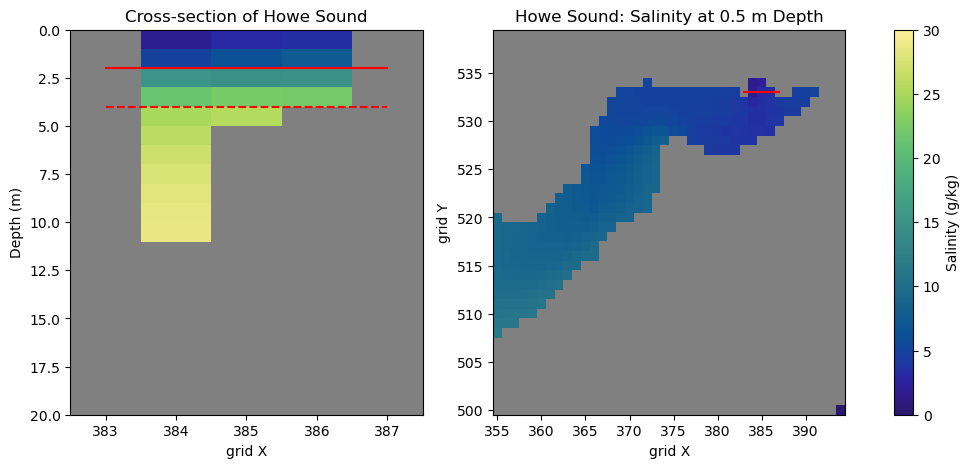

In [104]:
xmin = 28
xmax = 32
yval = 33
max_depth = 20
depth_div = 2
depth_show = 0
depth_mixing = 4

cmap = cm.haline
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 2, figsize=(12.5, 5))
salinity = np.ma.masked_array(phys_sal[:, yval, xmin:xmax+1], mask=tmask_howe[:, yval, xmin:xmax+1])
colours = ax[0].pcolormesh(physics.gridX[xmin:xmax+1], physics.depth, salinity, cmap=cmap,vmin=0,vmax=30)
ax[0].set_ylim(0, max_depth)
ax[0].invert_yaxis();
cb = fig.colorbar(colours, ax=ax)
cb.set_label('Salinity (g/kg)');
ax[0].set_title('Cross-section of Howe Sound')
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('grid X')
ax[0].plot(np.arange(xmin, xmax+1)+355, np.zeros(len(np.arange(xmin, xmax+1)))+depth_div, 'r')
ax[0].plot(np.arange(xmin, xmax+1)+355, np.zeros(len(np.arange(xmin, xmax+1)))+depth_mixing, 'r',linestyle='--')


salinity = np.ma.masked_array(phys_sal[depth_show], mask=tmask_howe[depth_div])
colours = ax[1].pcolormesh(physics.gridX[0:40+1], physics.gridY[0:40+1], salinity, cmap=cmap,vmin=0,vmax=30)
ax[1].plot(np.arange(xmin, xmax+1)+355, np.zeros(len(np.arange(xmin, xmax+1)))+yval+500,'r')
ax[1].set_title('Howe Sound: Salinity at {} m Depth'.format(str(np.round(physics.depth[depth_show].values,2))))
ax[1].set_xlabel('grid X')
ax[1].set_ylabel('grid Y')

Text(0, 0.5, 'grid Y')

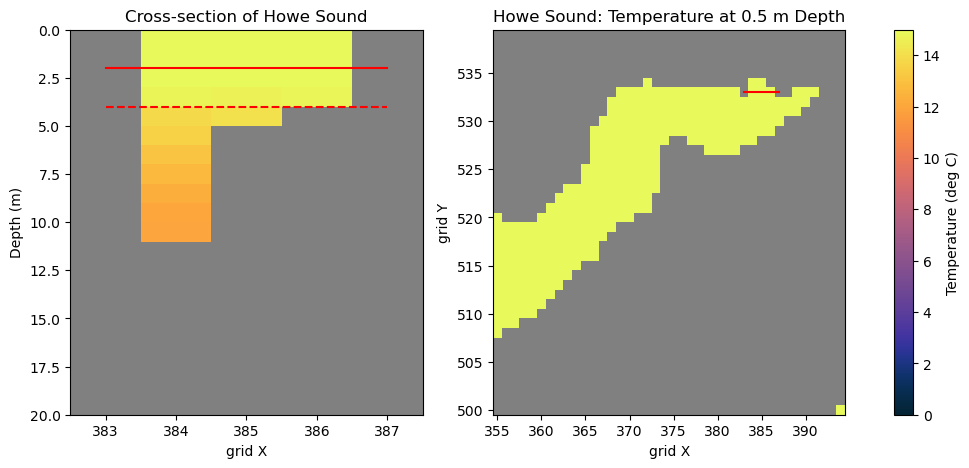

In [105]:
cmap = cm.thermal
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 2, figsize=(12.5, 5))
temper = np.ma.masked_array(phys_temp[:, yval, xmin:xmax+1], mask=tmask_howe[:, yval, xmin:xmax+1])
colours = ax[0].pcolormesh(physics.gridX[xmin:xmax+1], physics.depth, temper, cmap=cmap,vmin=0,vmax=15)
ax[0].set_ylim(0, max_depth)
ax[0].invert_yaxis();
cb = fig.colorbar(colours, ax=ax)
cb.set_label('Temperature (deg C)');
ax[0].set_title('Cross-section of Howe Sound')
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('grid X')
ax[0].plot(np.arange(xmin, xmax+1)+355, np.zeros(len(np.arange(xmin, xmax+1)))+depth_div, 'r')
ax[0].plot(np.arange(xmin, xmax+1)+355, np.zeros(len(np.arange(xmin, xmax+1)))+depth_mixing, 'r',linestyle='--')


temper = np.ma.masked_array(phys_temp[depth_show], mask=tmask_howe[depth_div])
colours = ax[1].pcolormesh(physics.gridX[0:40+1], physics.gridY[0:40+1], temper, cmap=cmap,vmin=0,vmax=15)
ax[1].plot(np.arange(xmin, xmax+1)+355, np.zeros(len(np.arange(xmin, xmax+1)))+yval+500,'r')
ax[1].set_title('Howe Sound: Temperature at {} m Depth'.format(str(np.round(physics.depth[depth_show].values,2))))
ax[1].set_xlabel('grid X')
ax[1].set_ylabel('grid Y')

Text(0, 0.5, 'grid Y')

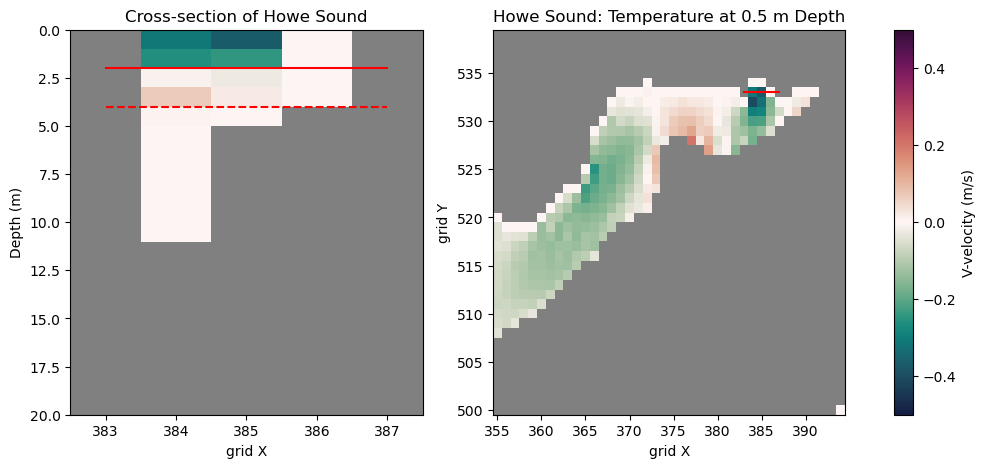

In [106]:
cmap = cm.curl
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 2, figsize=(12.5, 5))
temper = np.ma.masked_array(vvel[:, yval, xmin:xmax+1], mask=tmask_howe[:, yval, xmin:xmax+1])
colours = ax[0].pcolormesh(physics.gridX[xmin:xmax+1], physics.depth, temper, cmap=cmap,vmin=-0.5,vmax=0.5)
ax[0].set_ylim(0, max_depth)
ax[0].invert_yaxis();
cb = fig.colorbar(colours, ax=ax)
cb.set_label('V-velocity (m/s)');
ax[0].set_title('Cross-section of Howe Sound')
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('grid X')
ax[0].plot(np.arange(xmin, xmax+1)+355, np.zeros(len(np.arange(xmin, xmax+1)))+depth_div, 'r')
ax[0].plot(np.arange(xmin, xmax+1)+355, np.zeros(len(np.arange(xmin, xmax+1)))+depth_mixing, 'r',linestyle='--')


temper = np.ma.masked_array(vvel[depth_show], mask=tmask_howe[depth_div])
colours = ax[1].pcolormesh(physics.gridX[0:40+1], physics.gridY[0:40+1], temper, cmap=cmap,vmin=-0.5,vmax=0.5)
ax[1].plot(np.arange(xmin, xmax+1)+355, np.zeros(len(np.arange(xmin, xmax+1)))+yval+500,'r')
ax[1].set_title('Howe Sound: Temperature at {} m Depth'.format(str(np.round(physics.depth[depth_show].values,2))))
ax[1].set_xlabel('grid X')
ax[1].set_ylabel('grid Y')

In [107]:
top_slice_sal = phys_sal[:, yval, xmin:xmax+1][0:depth_div, :]
bot_slice_sal = phys_sal[:, yval, xmin:xmax+1][depth_div:40, :]

top_slice_temp = phys_temp[:, yval, xmin:xmax+1][0:depth_div, :]
bot_slice_temp = phys_temp[:, yval, xmin:xmax+1][depth_div:40, :]

top_slice_vvel = vvel[:, yval, xmin:xmax+1][0:depth_div, :]
bot_slice_vvel = vvel[:, yval, xmin:xmax+1][depth_div:40, :]

ml_slice_vvel = vvel[:, yval, xmin:xmax+1][0:depth_mixing, :]
uml_slice_vvel = vvel[:, yval, xmin:xmax+1][depth_mixing:40, :]

In [108]:
def avg_layers(top_slice,bot_slice,depth_div):
    sel_water = tmask_howe[:, yval, xmin:xmax+1][0:depth_div, :].to_numpy().flatten() == 0
    top_layer = top_slice.to_numpy().flatten()[sel_water]
    p_top = np.mean(top_layer)

    sel_water = tmask_howe[:, yval, xmin:xmax+1][depth_div:40, :].to_numpy().flatten() == 0
    bot_layer = bot_slice.to_numpy().flatten()[sel_water]
    p_bot = np.mean(bot_layer)

    return list([p_top, p_bot])

In [109]:
S_top, S_bot = avg_layers(top_slice_sal, bot_slice_sal, depth_div)
T_top, T_bot = avg_layers(top_slice_temp, bot_slice_temp, depth_div)
V_top, V_bot = avg_layers(top_slice_vvel, bot_slice_vvel, depth_div)
V_mix = avg_layers(ml_slice_vvel, uml_slice_vvel, depth_mixing)[0]
rho_top = gsw.rho_t_exact(S_top, T_top, physics.depth[depth_div].values)
rho_bot = gsw.rho_t_exact(S_bot, T_bot, physics.depth[depth_div].values)

In [110]:
print('S_top = {} g/kg, T_top = {} deg C, V_top = {} m/s N'.format(str(round(S_top, 2)), str(round(T_top, 2)), str(round(V_top, 4))))
print('S_bot = {} g/kg, T_bot = {} deg C, V_bot = {} m/s N'.format(str(round(S_bot, 2)), str(round(T_bot, 2)), str(round(V_bot, 4))))
print('V_mix = {} m/s'.format(str(round(V_mix, 4))))
print('rho_top = {} kg/m^3'.format(str(round(rho_top, 2))))
print('rho_bot = {} kg/m^3'.format(str(round(rho_bot, 2))))
print('Qr = {} m^3/s'.format(str(round(mid_mean, 2))))

S_top = 4.53 g/kg, T_top = 15.9 deg C, V_top = -0.1974 m/s N
S_bot = 23.29 g/kg, T_bot = 13.86 deg C, V_bot = 0.0046 m/s N
V_mix = -0.0941 m/s
rho_top = 1002.44 kg/m^3
rho_bot = 1017.12 kg/m^3
Qr = 241.86 m^3/s


## Look at the salt wedge if it's there

In [111]:
def FR_2(Qr, epsilon, g, B, H):
    return Qr**2 / (epsilon * g * B**2 * H**3)


def lambda_s(FR_2):
    return (1/10 - FR_2 + (3/2)*FR_2**(4/3) - (3/5)*FR_2**(5/3))


def L_s(FR_2, H, fI):
    return (1/10 - FR_2 + (3/2)*FR_2**(4/3) - (3/5)*FR_2**(5/3)) * (H / (fI * FR_2))


def interface(FR_2, H):
    return (1 - FR_2**(1/3)) * H


def u1(Qr, B, H):
    return Qr/(B * H)


def chi(lambda_s, FR_2, eta):
    return  (1/lambda_s) * (1/10 - FR_2*(eta**2 - 2*eta + 1) - 0.5*eta**4 + (2/5)*eta**5)

In [112]:
epsilon = (rho_bot - rho_top)/rho_bot
g_prime = 9.81 * epsilon
width_river = 200  # meters, found using google earth
depth_river = 10  # meters (change this?) found by looking at the 2D cross section from Hage et al
fI = 0.01  # estimate based on in-class assignment, see if I can get a better value for this somewhere else

In [113]:
Fr2 = FR_2(mid_mean, epsilon, g_prime, width_river, depth_river)
lam_s = lambda_s(Fr2)
eta_e = (Fr2)**(1/3)
eta_arr = np.linspace(eta_e, 1, 100)
length = L_s(Fr2, depth_river, fI)
interface_height = interface(Fr2, depth_river)
u_interface = u1(mid_mean, width_river, depth_river)
chi_arr = chi(lam_s, Fr2, eta_arr)

In [114]:
print('River Froude Number: {}'.format(str(round(np.sqrt(Fr2), 4))))
print('Salt Wedge Length: {} meters'.format(str(round(length, -1))))
print('River Mouth Interface Height: {} meters'.format(str(round(interface_height, 2))))
print('River Mouth Interface Depth: {} meters'.format(str(round(10-interface_height, 2))))
print('River Exit Velocity: {} m/s'.format(str(round(u_interface,4))))

River Froude Number: 0.8461
Salt Wedge Length: 0.0 meters
River Mouth Interface Height: 1.05 meters
River Mouth Interface Depth: 8.95 meters
River Exit Velocity: 0.1209 m/s


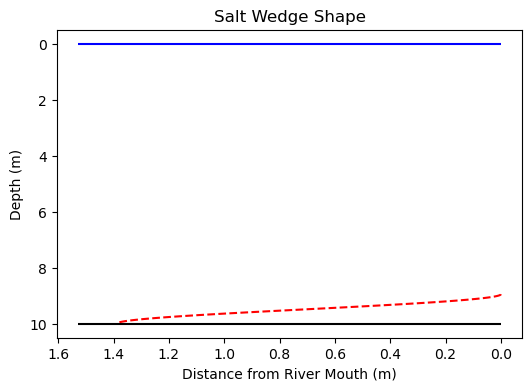

In [115]:
fig1, ax1 = plt.subplots(1,1,figsize=(6,4))

ax1.plot(length*(1-chi_arr),10-((1-eta_arr)*depth_river),'r--')
ax1.hlines(0, 0, 1.1*length, 'b')
ax1.hlines(10, 0, 1.1*length, 'k')
ax1.set_title('Salt Wedge Shape')
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel('Distance from River Mouth (m)')
ax1.invert_xaxis()
ax1.invert_yaxis()

# Go back and draw a prime transect to look at the entrainment

In [116]:
D_int = 10-interface_height
h0 = np.array([D_int, 10]).min()
D_ind = int(np.abs(physics.depth - h0).argmin().values)

Text(0, 0.5, 'grid Y')

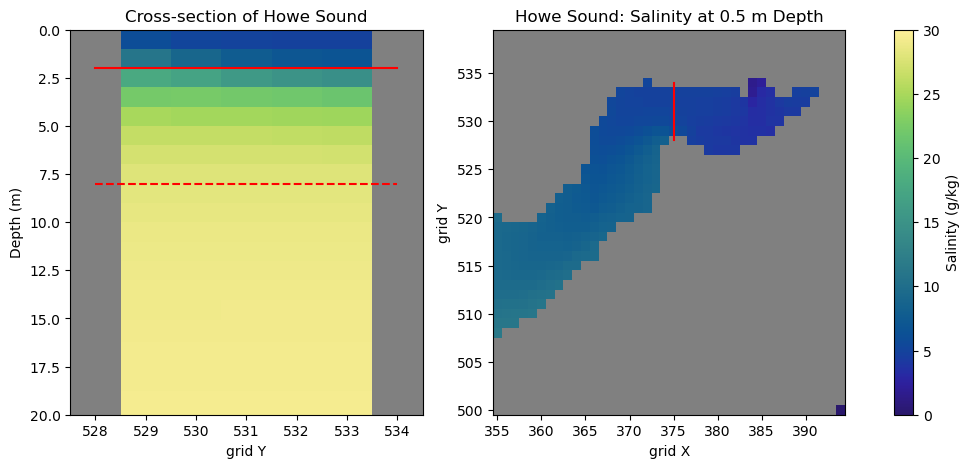

In [124]:
ymin = 28
ymax = 34
xval = 20
max_depth = 20
depth_div = 2
depth_show = 0
depth_mixing = D_ind

cmap = cm.haline
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 2, figsize=(12.5, 5))
salinity = np.ma.masked_array(phys_sal[:, ymin:ymax+1, xval], mask=tmask_howe[:, ymin:ymax+1, xval])
colours = ax[0].pcolormesh(physics.gridY[ymin:ymax+1], physics.depth, salinity, cmap=cmap,vmin=0,vmax=30)
ax[0].set_ylim(0, max_depth)
ax[0].invert_yaxis();
cb = fig.colorbar(colours, ax=ax)
cb.set_label('Salinity (g/kg)');
ax[0].set_title('Cross-section of Howe Sound')
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('grid Y')
ax[0].plot(np.arange(ymin, ymax+1)+500, np.zeros(len(np.arange(ymin, ymax+1)))+depth_div, 'r')
ax[0].plot(np.arange(ymin, ymax+1)+500, np.zeros(len(np.arange(ymin, ymax+1)))+depth_mixing, 'r',linestyle='--')


salinity = np.ma.masked_array(phys_sal[depth_show], mask=tmask_howe[depth_div])
colours = ax[1].pcolormesh(physics.gridX[0:40+1], physics.gridY[0:40+1], salinity, cmap=cmap,vmin=0,vmax=30)
ax[1].plot(np.zeros(len(np.arange(ymin, ymax+1)))+xval+355, np.arange(ymin, ymax+1)+500, 'r')
ax[1].set_title('Howe Sound: Salinity at {} m Depth'.format(str(np.round(physics.depth[depth_show].values,2))))
ax[1].set_xlabel('grid X')
ax[1].set_ylabel('grid Y')

Text(0, 0.5, 'grid Y')

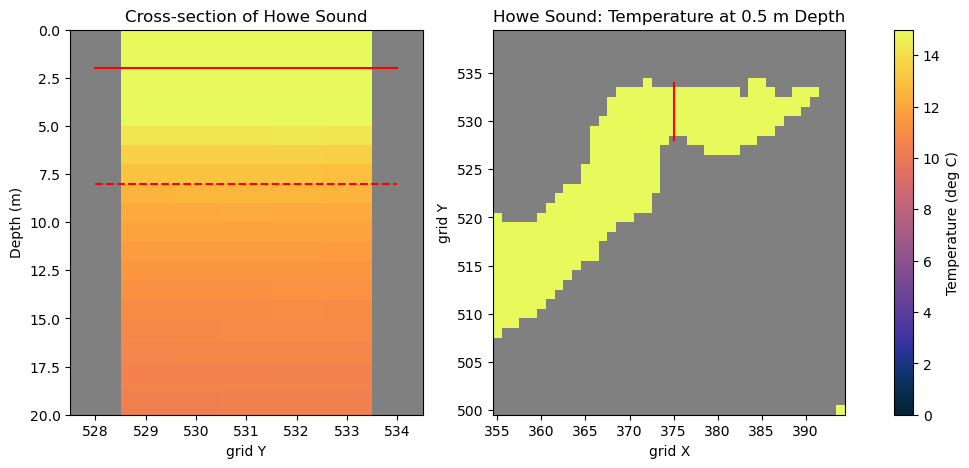

In [125]:
cmap = cm.thermal
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 2, figsize=(12.5, 5))
temper = np.ma.masked_array(phys_temp[:, ymin:ymax+1, xval], mask=tmask_howe[:, ymin:ymax+1, xval])
colours = ax[0].pcolormesh(physics.gridY[ymin:ymax+1], physics.depth, temper, cmap=cmap,vmin=0,vmax=15)
ax[0].set_ylim(0, max_depth)
ax[0].invert_yaxis();
cb = fig.colorbar(colours, ax=ax)
cb.set_label('Temperature (deg C)');
ax[0].set_title('Cross-section of Howe Sound')
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('grid Y')
ax[0].plot(np.arange(ymin, ymax+1)+500, np.zeros(len(np.arange(ymin, ymax+1)))+depth_div, 'r')
ax[0].plot(np.arange(ymin, ymax+1)+500, np.zeros(len(np.arange(ymin, ymax+1)))+depth_mixing, 'r',linestyle='--')


temper = np.ma.masked_array(phys_temp[depth_show], mask=tmask_howe[depth_div])
colours = ax[1].pcolormesh(physics.gridX[0:40+1], physics.gridY[0:40+1], temper, cmap=cmap,vmin=0,vmax=15)
ax[1].plot(np.zeros(len(np.arange(ymin, ymax+1)))+xval+355, np.arange(ymin, ymax+1)+500, 'r')
ax[1].set_title('Howe Sound: Temperature at {} m Depth'.format(str(np.round(physics.depth[depth_show].values,2))))
ax[1].set_xlabel('grid X')
ax[1].set_ylabel('grid Y')

Text(0, 0.5, 'grid Y')

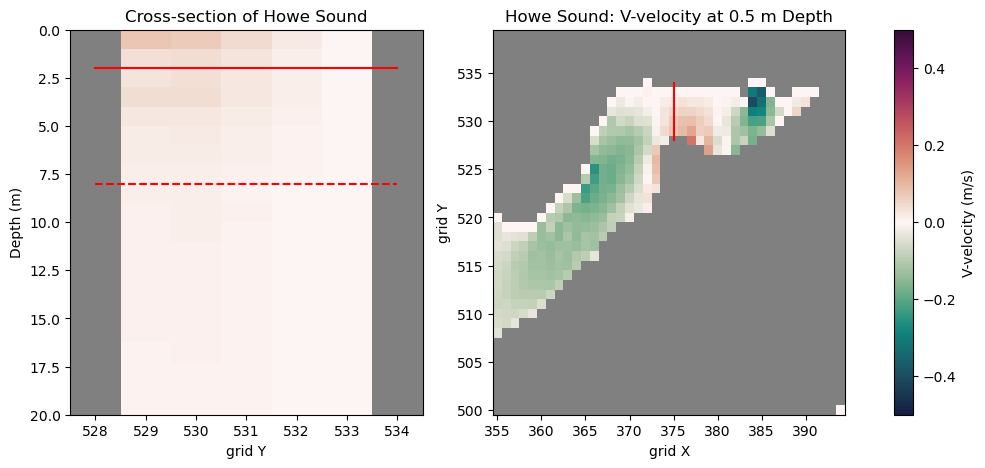

In [126]:
cmap = cm.curl
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 2, figsize=(12.5, 5))
temper = np.ma.masked_array(vvel[:, ymin:ymax+1, xval], mask=tmask_howe[:, ymin:ymax+1, xval])
colours = ax[0].pcolormesh(physics.gridY[ymin:ymax+1], physics.depth, temper, cmap=cmap,vmin=-0.5,vmax=0.5)
ax[0].set_ylim(0, max_depth)
ax[0].invert_yaxis();
cb = fig.colorbar(colours, ax=ax)
cb.set_label('V-velocity (m/s)');
ax[0].set_title('Cross-section of Howe Sound')
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('grid Y')
ax[0].plot(np.arange(ymin, ymax+1)+500, np.zeros(len(np.arange(ymin, ymax+1)))+depth_div, 'r')
ax[0].plot(np.arange(ymin, ymax+1)+500, np.zeros(len(np.arange(ymin, ymax+1)))+depth_mixing, 'r',linestyle='--')


temper = np.ma.masked_array(vvel[depth_show], mask=tmask_howe[depth_div])
colours = ax[1].pcolormesh(physics.gridX[0:40+1], physics.gridY[0:40+1], temper, cmap=cmap,vmin=-0.5,vmax=0.5)
ax[1].plot(np.zeros(len(np.arange(ymin, ymax+1)))+xval+355, np.arange(ymin, ymax+1)+500, 'r')
ax[1].set_title('Howe Sound: V-velocity at {} m Depth'.format(str(np.round(physics.depth[depth_show].values,2))))
ax[1].set_xlabel('grid X')
ax[1].set_ylabel('grid Y')

In [127]:
top_slice_prime_sal = phys_sal[:, ymin:ymax+1, xval][0:depth_div, :]
bot_slice_prime_sal = phys_sal[:, ymin:ymax+1, xval][depth_div:40, :]

top_slice_prime_temp = phys_temp[:, ymin:ymax+1, xval][0:depth_div, :]
bot_slice_prime_temp = phys_temp[:, ymin:ymax+1, xval][depth_div:40, :]

top_slice_prime_vvel = vvel[:, ymin:ymax+1, xval][0:depth_div, :]
bot_slice_prime_vvel = vvel[:, ymin:ymax+1, xval][depth_div:40, :]

ml_slice_prime_vvel = vvel[:, ymin:ymax+1, xval][0:depth_mixing, :]
uml_slice_prime_vvel = vvel[:, ymin:ymax+1, xval][depth_mixing:40, :]

In [128]:
def avg_layers_90(top_slice,bot_slice,depth_div):
    sel_water = tmask_howe[:, ymin:ymax+1, xval][0:depth_div, :].to_numpy().flatten() == 0
    top_layer = top_slice.to_numpy().flatten()[sel_water]
    p_top = np.mean(top_layer)

    sel_water = tmask_howe[:, ymin:ymax+1, xval][depth_div:40, :].to_numpy().flatten() == 0
    bot_layer = bot_slice.to_numpy().flatten()[sel_water]
    p_bot = np.mean(bot_layer)

    return list([p_top, p_bot])

In [129]:
S_top_prime, S_bot_prime = avg_layers_90(top_slice_prime_sal, bot_slice_prime_sal, depth_div)
T_top_prime, T_bot_prime = avg_layers_90(top_slice_prime_temp, bot_slice_prime_temp, depth_div)
V_top_prime, V_bot_prime = avg_layers_90(top_slice_prime_vvel, bot_slice_prime_vvel, depth_div)
V_mix_prime = avg_layers_90(ml_slice_prime_vvel, uml_slice_prime_vvel, depth_mixing)[0]
rho_top_prime = gsw.rho_t_exact(S_top_prime, T_top_prime, physics.depth[depth_div].values)
rho_bot_prime = gsw.rho_t_exact(S_bot_prime, T_bot_prime, physics.depth[depth_div].values)

In [130]:
print('S_top_prime = {} g/kg, T_top_prime = {} deg C, V_top_prime = {} m/s N'.format(str(round(S_top_prime, 2)), str(round(T_top_prime, 2)), str(round(V_top_prime, 4))))
print('S_bot_prime = {} g/kg, T_bot_prime = {} deg C, V_bot_prime = {} m/s N'.format(str(round(S_bot_prime, 2)), str(round(T_bot_prime, 2)), str(round(V_bot_prime, 4))))

S_top_prime = 6.73 g/kg, T_top_prime = 16.37 deg C, V_top_prime = 0.0334 m/s N
S_bot_prime = 28.34 g/kg, T_bot_prime = 11.3 deg C, V_bot_prime = 0.0058 m/s N
